In [17]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import subprocess
from dtw import correlate
import json
import librosa
import librosa.display
import IPython.display as ipd
import math
import csv
import matplotlib.pyplot as plt

MAX_AUDIO_DURATION_MS = 8 * 1000
MAX_SAMPLE_COMPARISON_COUNT = 1000

apppath = os.path.expanduser(os.getcwd() + '/')
#mediapath = os.path.expanduser('/mnt/freesound-crawler/')
#mediapath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/')
mediapath = os.path.expanduser('/Users/andrusasumets/Desktop/freesound-crawler/')
processedpath = os.path.join(mediapath, 'processed/')
soxipath = os.path.join(processedpath, 'soxi/')
wavpath = os.path.join(processedpath, 'wav/')
audiopath = os.path.join(processedpath, 'audio/')
convertedpath = os.path.join(processedpath, 'converted/')
normalizedpath = os.path.join(processedpath, 'normalized/')
silencedpath = os.path.join(processedpath, 'silenced/')
dtwpath = os.path.join(processedpath, 'dtw/')
preselectedpath = os.path.join(processedpath, 'preselected/')
excludedpath = os.path.join(processedpath, 'excluded/')
extensionpath = os.path.join(apppath, 'Extension/data/')
extensionsamplepath = os.path.join(extensionpath, 'samples/')
librarypath = os.path.join(mediapath, 'downloads/')
metadatapath = os.path.join(mediapath, 'metadata/')
metadatacsvpath = os.path.join(processedpath, 'metadata.csv')
allowedfileformats = ['wav', 'aiff', 'flac', 'ogg', 'mp3', 'm4a']
processfileformat = 'wav'
exportfileformat = 'm4a'

for p in [processedpath, soxipath, wavpath, audiopath, convertedpath, normalizedpath, silencedpath, dtwpath, excludedpath, extensionpath, extensionsamplepath]:
    if not os.path.exists(p):
        os.makedirs(p)

In [18]:
def read_csv(filename):
    with open(filename) as f:
        file_data = csv.reader(f)
        headers = next(file_data)
        return [dict(zip(headers, i)) for i in file_data] 
    
def process(command, verbose=False):
    if verbose:
        print(' '.join(command))
    subprocess.Popen(command, shell=False)
    
def get_fileformat(filename):
    return filename.split('.')[len(filename.split('.')) - 1]

def create_or_read_file(command, outfilename):
    if os.path.exists(outfilename):
        f = open(outfilename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(outfilename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [19]:
ids = [f for f in os.listdir(metadatapath)]
print(len(ids))

if not os.path.exists(metadatacsvpath):
    fieldnames = ['id', 'duration', 'downloads', 'rating', 'numratings', 'tags']
    rows = []

    for id in ids:        
        with open(metadatapath + "/" + id) as file:
            try:
                id = int(id)
                line = file.readlines()[0]
                arguments = line.split('|')
                duration = int(arguments[0].split('duration:')[1])
                downloads = int(arguments[1].split('downloads:')[1])
                rating = int(arguments[2].split('rating:')[1])
                numratings = int(arguments[3].split('numratings:')[1])
                tags = arguments[4].split('tags:')[1]
                row = {
                    'id': id,
                    'duration': duration,
                    'downloads': downloads,
                    'rating': rating,
                    'numratings': numratings,
                    'tags': tags
                }
                rows.append(row)
            except Exception as e:
                print(e)

    with open(metadatacsvpath, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(rows)

metadata = read_csv(metadatacsvpath)

68455


In [20]:
def parse_ids(path, fileformat):
    result = [f for f in os.listdir(path)]
    result = [f for f in result if f.endswith(fileformat)]
    result = [f.split('-')[0] for f in result]
    return result

preselected = parse_ids(preselectedpath, exportfileformat)
excluded = parse_ids(excludedpath, exportfileformat)

In [21]:
DOWNLOADS_THRESHOLD = 10
RATING_THRESHOLD = 90
MIN_NUMRATINGS = 3

scored = []
for sample in metadata:            
    id = sample['id']
    if id in excluded and id not in preselected:
        continue

    duration = int(sample['duration'])
    downloads = int(sample['downloads'])
    rating = int(sample['rating'])
    numratings = int(sample['numratings'])
    tags = sample['tags']

    if len(tags) > 0 and downloads >= DOWNLOADS_THRESHOLD and rating >= RATING_THRESHOLD and numratings >= MIN_NUMRATINGS:
        row = [id, duration, downloads, rating, numratings, tags, rating * downloads]
        scored.append(row)

print(len(scored))

scored.sort(key=lambda x: int(x[6]))
scored.reverse()

print(scored[0])

1701
['490951', 34791, 19603, 93, 187, 'video,game,Footsteps,ground,dirty,footsteps,foot,step,tile,feet,walk,snow,Footstep,field-recording,water', 1823079]


In [22]:
samples = {}

for row in scored:
    id = row[0]
    samples[id] = {
        'duration': row[1],
        'downloads': row[2],
        'rating': row[3],
        'numratings': row[4],
        'tags': row[5],
        'score': row[6],
    }
    
print(len(list(samples)))
print(samples[scored[0][0]])

1701
{'duration': 34791, 'downloads': 19603, 'rating': 93, 'numratings': 187, 'tags': 'video,game,Footsteps,ground,dirty,footsteps,foot,step,tile,feet,walk,snow,Footstep,field-recording,water', 'score': 1823079}


In [23]:
all_filenames = [f for f in os.listdir(librarypath)]
fileformats = {}
for filename in all_filenames:
    fileformat = get_fileformat(filename)
    
    if fileformat not in fileformats:
        fileformats[fileformat] = 0
         
    fileformats[fileformat] = fileformats[fileformat] + 1
    
print('fileformats', fileformats)
print('all_filenames:', len(all_filenames))

filenames = [f for f in os.listdir(librarypath) if f.endswith(tuple(allowedfileformats))]
filenames = [f for f in filenames if f.count('__') == 2]
filtered = []

for filename in filenames:
    id = filename.split('__')[0]
    
    if id in excluded:
        continue
    
    for row in scored:
        if row[0] == id:
            filtered.append(filename)
            
filenames = filtered
print('filtered filenames', len(filenames))

fileformats {'flac': 2888, 'wav': 46250, 'mp3': 2936, 'aiff': 19174, 'ogg': 679, 'm4a': 142, 'crdownload': 15, 'DS_Store': 1}
all_filenames: 72085
filtered filenames 1695


In [24]:
exportedfilenames = [f for f in os.listdir(audiopath) if f.endswith(exportfileformat)]

test = [f.split('__')[0] for f in filenames]

exported = []
for filename in filenames:
    try:
        fileartist = filename.split("__")[1].split("__")[0]
        fileid = filename.split('__')[0]
        audiofilename = fileid + '.' + processfileformat
        exportfilename = fileid + '.' + exportfileformat
        
        if samples[fileid]['duration'] > MAX_AUDIO_DURATION_MS:
            continue
        
        if exportfilename not in exportedfilenames:
            process(['ffmpeg', '-loglevel', 'error', '-i', librarypath + filename, '-acodec', 'pcm_s16le', '-ar', '44100', '-threads', '6', convertedpath + audiofilename])
            process(['ffmpeg-normalize', convertedpath + audiofilename, '-o', normalizedpath + audiofilename, '-f'])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + audiofilename, '-af', 'silenceremove=1:0:-50dB', '-threads', '6', silencedpath + audiofilename])
            process(['ffmpeg', '-loglevel', 'error', '-i', silencedpath + audiofilename, '-c:a', 'aac', '-ar', '44100', '-threads', '6', audiopath + exportfilename])
            process(['ffmpeg', '-loglevel', 'error', '-i', silencedpath + audiofilename, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '100', '-threads', '6', wavpath + fileid + '.wav'])

        exported.append(fileid)
    except Exception as e:
        print(e)

for id in preselected:
    if id not in exported:
        exported.append(id)

print(len(exported))

11


In [25]:
FREQUENCY_MULTIPLIER = 0.5

saved = []
for leftid in exported:
    if leftid in saved:
        continue

    source = audiopath + leftid + '.' + exportfileformat
    target = extensionsamplepath + leftid + '.' + exportfileformat
    target_breathe_in = extensionsamplepath + leftid + '-breathe-in.' + exportfileformat
    target_breathe_out = extensionsamplepath + leftid + '-breathe-out.' + exportfileformat

    try:
        if not os.path.isfile(target_breathe_in):
            process(['ffmpeg', '-i', source, '-af', 'asetrate=44100*' + str(FREQUENCY_MULTIPLIER) + ',aresample=44100,atempo=1/' + str(FREQUENCY_MULTIPLIER), target_breathe_in])

        if not os.path.isfile(target_breathe_out):
            process(['cp', source, target_breathe_out])

        saved.append(leftid)
 
    except Exception as e:
        print(e)

In [26]:
#EXPORTED_COUNT = 10
EXPORTED_COUNT = len(exported)

df = pd.DataFrame()
out_distances = {}
full_distances = []

for leftfilename in exported[0:EXPORTED_COUNT]:
    leftid = leftfilename.split('.')[0]
    
    for righti, rightfilename in enumerate(exported[0:EXPORTED_COUNT]):
        if (len(full_distances) % 100) == 0 and righti == 0:
            print(str(len(full_distances)) + " / " + str(len(exported) * MAX_SAMPLE_COMPARISON_COUNT))
            
        if righti >= MAX_SAMPLE_COMPARISON_COUNT:
            continue
        
        if leftfilename == rightfilename:
            continue
            
        rightid = rightfilename.split('.')[0]
            
        try:
            correlation = correlate(wavpath, leftid, rightid, 'wav', dtwpath)
            
            if math.isinf(float(correlation)):
                continue
                
            if math.isnan(float(correlation)):
                continue
            
            df.loc[leftid, rightid] = correlation
            df.loc[rightid, leftid] = correlation

            if leftid not in out_distances:
                out_distances[leftid] = []
            
            duration = samples[leftid]['duration']
            
            print(leftid, rightid)
            out_distances[leftid].append([correlation, duration, int(rightid)])
            full_distances.append([correlation, leftid, rightid])

        except Exception as e:
            pass

for filename in out_distances:
    out_distances[filename] = sorted(out_distances[filename])
    
full_distances = sorted(full_distances)
print(len(full_distances))

with open(extensionpath + 'distances.json', 'w') as fp:
    json.dump(out_distances, fp)

0 / 11000
346694 13858
346694 190096
346694 13868
346694 425727
346694 8835
346694 18082
346694 406735
346694 190112
346694 220178
346694 8838
190096 346694
190096 13858
190096 13868
190096 425727
190096 8835
190096 18082
190096 406735
190096 190112
190096 220178
190096 8838
8835 346694
8835 13858
8835 190096
8835 13868
8835 425727
8835 18082
8835 406735
8835 190112
8835 220178
8835 8838
406735 346694
406735 13858
406735 190096
406735 13868
406735 425727
406735 8835
406735 18082
406735 190112
406735 220178
406735 8838
8838 346694
8838 13858
8838 190096
8838 13868
8838 425727
8838 8835
8838 18082
8838 406735
8838 190112
8838 220178
50


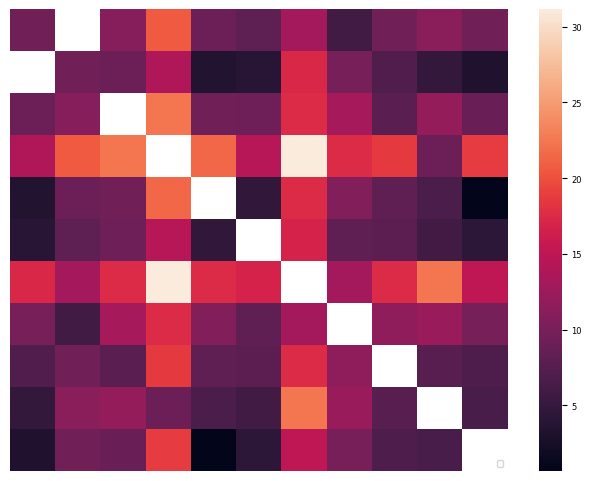

In [27]:
plot = sns.heatmap(df, xticklabels=False, yticklabels=False)
handles, labels = plot.get_legend_handles_labels()
plot.legend(reversed(handles), reversed(labels), title='', loc="lower right")
fig = plot.get_figure()
fig.tight_layout()

In [28]:
def show_sample(comparison):
    distance, leftid, rightid = comparison
    print(distance, leftid, rightid)

    data, rate = librosa.core.load(audiopath + leftid + '.' + exportfileformat)
    ipd.display(ipd.Audio(data, rate=rate))

    data, rate = librosa.core.load(audiopath + rightid + '.' + exportfileformat)
    ipd.display(ipd.Audio(data, rate=rate))

display_count = 10
for i in range(display_count):
    if (i % 2) == 0:
        show_sample(full_distances[i])
        
for i in range(display_count):
    if (i % 2) == 0:
        show_sample(full_distances[i - display_count])

0.6725286192831219 8838 425727


/var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/ipykernel_94437/1084326628.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  data, rate = librosa.core.load(audiopath + leftid + '.' + exportfileformat)
/Users/andrusasumets/.pyenv/versions/3.10.10/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/ipykernel_94437/1084326628.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  data, rate = librosa.core.load(audiopath + rightid + '.' + exportfileformat)


3.905124401312843 8835 13858


4.357601320413378 8838 8835


5.987836455511797 346694 406735


6.02532017934998 8835 220178


13.216276748630357 190096 406735


14.371032969513324 8835 13868


16.84526690662603 8835 18082


17.5217152654817 406735 13868


20.570673110585876 346694 13868


/var/folders/04/l5pwchfx0r19q9rbw6m653_80000gn/T/ipykernel_94437/2703785526.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  data, rate = librosa.core.load(path)


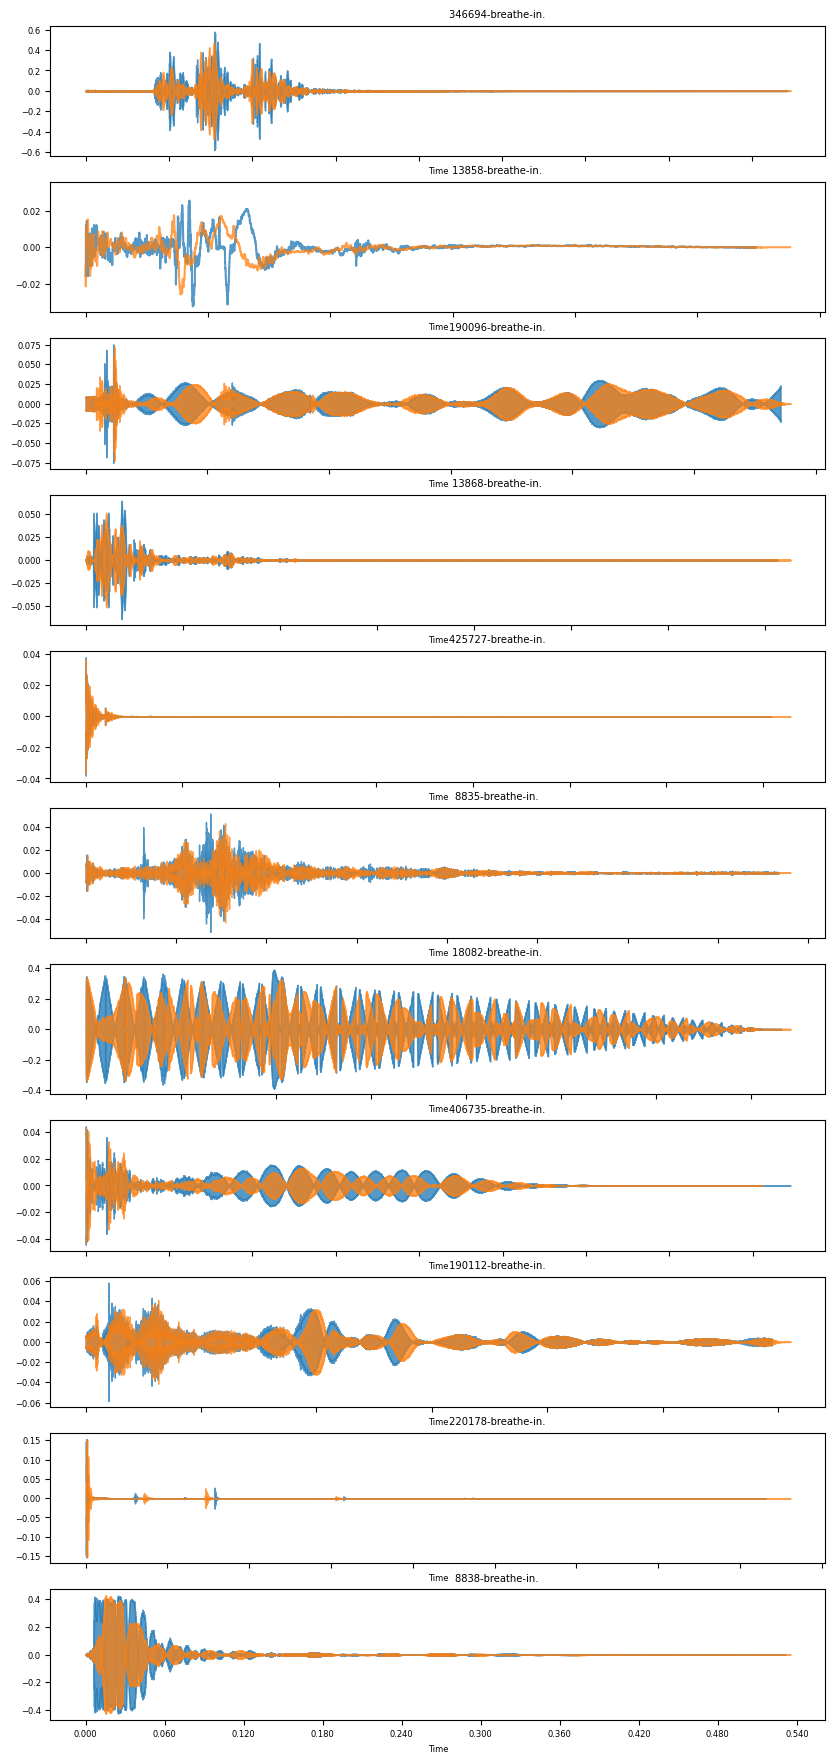

In [33]:
plots = saved[0:EXPORTED_COUNT]
plt.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(nrows=len(plots), figsize=(10, EXPORTED_COUNT * 2))

def waveform(id, ax):
    path = extensionsamplepath + id + exportfileformat
    data, rate = librosa.core.load(path)
    ax.set_title('⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀' + id)
    ax.label_outer()
    librosa.display.waveshow(data, sr=rate, ax=ax, alpha=0.75)

for idx, id in enumerate(plots):
    waveform(id + '-breathe-out.', ax[idx])
    waveform(id + '-breathe-in.', ax[idx])